# spaCy Spam Classifier

An implementation of a spam classifier using spaCy. The final result is a clasifier achieving an F Score of 0.9563 and accuracy of over 97%.

In [1]:
import json
import random
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

import spacy 
from spacy.util import compounding, minibatch

from utils import *
from pipeline import Pipeline

## Get a Corpus

Download the [Apache SpamAssassin public corpus](https://spamassassin.apache.org/old/publiccorpus/). A description of the corpus can be found [here](https://spamassassin.apache.org/old/publiccorpus/readme.html).

#### Categories
  - **Spam**: 1896 (31.4 %)
  - **Non Spam**: 4150 (68.6 %)
    - *Easy Ham*: 3900
    - *Hard Ham*: 250

In [2]:
# helper function from utils.py
files = download_and_extract_corpus(silent=True)

# determine category from file path
spam     = [f for f in files if 'spam' in f]
easy_ham = [f for f in files if 'easy_ham' in f]
hard_ham = [f for f in files if 'hard_ham' in f]

## Partition the Corpus 
Split the messages into two partitions with equal spam frequency and most of the hard ham in the second partition. Use the first partition for the training set and split the second between dev and test. This results in the following distribution:

  - **Training Set** : 4246 (70%)
  - **Dev Set** : 1200 (20%)
  - **Test Set** : 600 (10%)

In [3]:
easy_split = 1040
hard_split = 200
spam_split = 560
dev_size = 600

random.shuffle(easy_ham)
random.shuffle(hard_ham)
random.shuffle(spam)

part1 = easy_ham[:easy_split] + hard_ham[:hard_split] + spam[:spam_split]
random.shuffle(part1)

dev_files = part1[:dev_size]
test_files = part1[dev_size:]
train_files = easy_ham[easy_split:] + hard_ham[hard_split:] + spam[spam_split:]

random.shuffle(dev_files)
random.shuffle(test_files)
random.shuffle(train_files)

files = {
    'train': train_files,
    'dev'  : dev_files,
    'test' : test_files
}

## Parameter Tuning

### Preprocessing

Compare combinations of different header formatting and text preprocessing techniques. 

For the headers, we will use three different configurations: 
  - Full Headers
  - No Headers
  - Subject Field Only
  
For the text, we use the [Pipeline class](pipeline.py) with different combinations of the built-in preprocessing pipes. The :
  - Removing HTML tags - `html_cleaner`
  - Changing text to lowercase - `to_lower`
  - Removing punctuation - `punct_remover`
  - Removing stop words - `stopword_remover`
  - Lemmatize words - `lemmatizer`
    
The pipelines to test include `html_cleaner` and `to_lower` with different combinations of `punct_remover`, `stopword_remover`, and `lemmatizer`.

In [5]:
with open('partitions.json') as file_:
    files = json.load(file_)

def get_formatter(fields):
    def formatter(headers, body):
        return format_message_content(headers, body, header_fields=fields)
    return formatter

formatters = {
    'full_headers': format_message_content,
    'no_headers': get_formatter([]),
    'subject_only': get_formatter(['subject'])
}

pipes = ['to_lower', 'html_cleaner']
other_pipes = ['punct_remover', 'stopword_remover', 'lemmatizer']

bin_vectors = list(itertools.product((False, True), repeat=3))

combinations = []

lookups = spacy.lookups.Lookups().from_disk('.venv/lib/python3.8/site-packages/'
                                            'en_core_web_sm/en_core_web_sm-2.3.1/'
                                            'vocab/lookups.bin')

for v in bin_vectors:
    include = pipes + [other_pipes[i] for i in range(3) if v[i]]
    
    pipeline = Pipeline(include=include, lookups=lookups)
    for k, v in formatters.items():
        combinations.append({'pipeline': pipeline, 'formatter_name': k, 'formatter': v})

In [6]:
all_metrics = []
    
labeler = lambda y: {'SPAM': float(y), 'NOT_SPAM': float(not y)}
drop = 0.35
epochs = 10
textcat_config = {'exclusive_classes': True, 'architecture': 'ensemble'}

for i, combo in enumerate(combinations):
    if i < 6:
        continue
    pipeline = combo['pipeline']
    formatter = combo['formatter']
    format_name = combo['formatter_name']
    
    # get the data
    train_data = preprocess(files['train'], 
                            pipeline, 
                            lambda y: {'cats': labeler(y)}, 
                            silent=True,
                            formatter=formatter)
    dev_data = preprocess(files['dev'], 
                          pipeline, 
                          labeler,
                          silent=True,
                          formatter=formatter)
    
    # create a Language model with textcat
    nlp = spacy.blank('en')
    if 'textcat' in nlp.pipe_names:
        textcat = nlp.get_pipe('textcat')
    else:
        textcat = nlp.create_pipe('textcat', config=textcat_config)
        nlp.add_pipe(textcat, last=True)
        
    # add labels
    textcat.add_label('SPAM')
    textcat.add_label('NOT_SPAM')
    
    nlp, metrics, params = train_textcat(nlp, train_data, epochs, drop, dev_data)
    metrics['id'] = i
    metrics['drop'] = drop
    metrics['pipeline'] = pipeline.pipe_names
    metrics['format'] = format_name
    all_metrics.append(metrics)
    
    with open('all_metrics.json', 'w') as file_:
        json.dump(all_metrics, file_)

Training: 100%|██████████| 10/10 [04:40<00:00, 28.02s/ epoch]


#### Results

The top 10 combinations by F Score:

| ID  | F Score | Accuracy | Time (m) | Pipeline | Format |
|:---:|:-------:|:--------:|---------:|---------:|:------:|
|12|0.96124|0.97500|06:21|to_lower, html_cleaner, punct_remover|Full Headers|
|14|0.95855|0.97333|04:56|to_lower, html_cleaner, punct_remover|Subject Only|
|8|0.95607|0.97167|05:24|to_lower, html_cleaner, stopword_remover|Subject Only|
|18|0.95431|0.97000|05:30|to_lower, html_cleaner, punct_remover, stopword_remover|Full Headers|
|23|0.95238|0.97000|04:22|to_lower, html_cleaner, punct_remover, stopword_remover, lemmatizer|Subject Only|
|15|0.95141|0.96833|06:14|to_lower, html_cleaner, punct_remover, lemmatizer|Full Headers|
|17|0.94898|0.96667|04:58|to_lower, html_cleaner, punct_remover, lemmatizer|Subject Only|
|2|0.94764|0.96667|05:51|to_lower, html_cleaner|Subject Only|
|16|0.94602|0.96500|04:54|to_lower, html_cleaner, punct_remover, lemmatizer|No Headers|
|13|0.94545|0.96500|04:52|to_lower, html_cleaner, punct_remover|No Headers|

![Plots](img/fig1.png)


### Dropout Rate

Using only the header subject and pipeline with `to_lower`, `html_cleaner`, and `remove_punct`, compare performance on models trained with different dropout rates. 

In [43]:
labeler = lambda y: {'SPAM': float(y), 'NOT_SPAM': float(not y)}
drops = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
epochs = 10
textcat_config = {'exclusive_classes': True, 'architecture': 'ensemble'}
pipeline = combinations[14]['pipeline']
formatter = combinations[14]['formatter']
prev_metrics = all_metrics[14]
all_metrics = []

# get the data
train_data = preprocess(files['train'], 
                        pipeline, 
                        lambda y: {'cats': labeler(y)}, 
                        silent=True,
                        formatter=formatter)
dev_data = preprocess(files['dev'], 
                        pipeline, 
                        labeler,
                        silent=True,
                        formatter=formatter)
    
for i, drop in enumerate(drops):
    if drop == 0.35:
        prev_metrics['id'] = i + 24
        all_metrics.append(prev_metrics)
        continue
    
    # create model
    nlp = spacy.blank('en')
    if 'textcat' in nlp.pipe_names:
        textcat = nlp.get_pipe('textcat')
    else:
        textcat = nlp.create_pipe('textcat', config=textcat_config)
        nlp.add_pipe(textcat, last=True)
        
    # add labels
    textcat.add_label('SPAM')
    textcat.add_label('NOT_SPAM')
    
    # train
    nlp, metrics, params = train_textcat(nlp, train_data, epochs, drop, dev_data)
    metrics['id'] = i + 24
    metrics['drop'] = drop
    metrics['pipeline'] = pipeline.pipe_names
    metrics['format'] = prev_metrics['format']
    all_metrics.append(metrics)
    
    with open('_all_metrics.json', 'w') as file_:
        json.dump(all_metrics, file_)

Training: 100%|██████████| 10/10 [04:56<00:00, 29.67s/ epoch]


![fig3](img/fig3.png)

## Create and Train the Final Model

Use the optimal preprocessing pipeline on the data and train a new model with the optimal dropout rate.

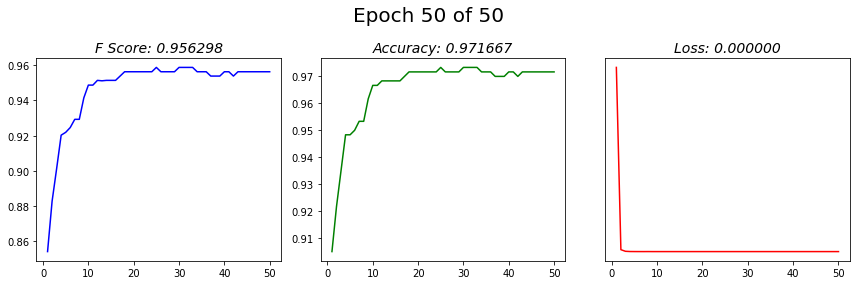

In [21]:
# Preprocess Data
formatter = get_formatter(['subject'])
pipeline = Pipeline(['to_lower', 'html_cleaner', 'remove_punct'])
labeler = lambda y: {'SPAM': float(y), 'NOT_SPAM': float(not y)}
cats = lambda y: {'cats': labeler(y)}
train_data = preprocess(files['train'], 
                        pipeline=pipeline, 
                        labeler=cats, 
                        silent=True,
                        formatter=formatter)
dev_data = preprocess(files['dev'], 
                        pipeline=pipeline, 
                        labeler=labeler,
                        silent=True,
                        formatter=formatter)
dev_texts, dev_golds = zip(*dev_data)

# Train settings
drop = 0.25
epochs = 50

# Track performance with plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), tight_layout=True)
plot_kwargs = {'colors': ['b', 'g', 'r'], 
               'yscale': [None, None, 'log'], 
               'y_ticks': [None, None, []]}
metrics = {'f_score': [], 'accuracy': [], 'loss': []}

# create the model
nlp = spacy.blank('en')
if 'textcat' in nlp.pipe_names:
    textcat = nlp.get_pipe('textcat')
else:
    textcat = nlp.create_pipe('textcat', config={'exclusive_classes': True, 
                                                 'architecture': 'ensemble'})
    nlp.add_pipe(textcat, last=True)
        
# add labels
textcat.add_label('SPAM')
textcat.add_label('NOT_SPAM')

other_pipes = [p for p in nlp.pipe_names if p != 'textcat']

with nlp.disable_pipes(*other_pipes):
    opt = nlp.begin_training()
    batch_sizes = compounding(16.0, 512, 1.01)
    
    for i in range(1, epochs + 1):
        losses = {}
        random.shuffle(train_data)
        
        for batch in minibatch(train_data, size=batch_sizes):
            texts, golds = zip(*batch)
            nlp.update(texts, golds, sgd=opt, drop=drop, losses=losses)
            
        # update metrics
        metrics['loss'].append(losses['textcat'])
        with textcat.model.use_params(opt.averages):
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_golds)
        metrics['f_score'].append(scores['f_score'])
        metrics['accuracy'].append(scores['accuracy'])
        
        #update plots
        update_metrics_axes(axes, list(metrics.items()), **plot_kwargs)
        fig.suptitle(f'Epoch {i} of {epochs}', fontsize=20)
        fig.canvas.draw()
        display.display(fig)
        display.clear_output(wait=True)

# save the model
with nlp.use_params(opt.averages):
    nlp.to_disk('output')

## Final Evaluation

![fig4](img/fig4.png)